In [1]:
import glob
import json
from os.path import dirname

import matplotlib.pyplot as plt
import numpy as np

exp002a_path = "../../logs/exp002/exp002a/sweep-2025-11-24_17-53-45_nchannels/"

exp002a_glob = f"{exp002a_path}/*/anysleep_test_results_n_channels.json"
exp002a_files = sorted(glob.glob(exp002a_glob), key=lambda x: int(x.split("/")[-2]))

mf1_per_n_ch_exp002a = {}
mf1_per_n_ch_exp002a_no_eog = {}
for file in exp002a_files:
    with open(dirname(file) + "/eval_downstream.log") as f:
        lines = f.readlines()
        n_eeg_line = [line for line in lines if "n_eeg_channels" in line][0]
        n_eeg_ch = int(n_eeg_line.split("=")[1])
        n_eog_line = [line for line in lines if "n_eog_channels" in line][0]
        n_eog_ch = int(n_eog_line.split("=")[1])
        model_line = [line for line in lines if "model" in line][0]
        model = model_line.split("=")[1].strip()
    with open(file) as f:
        results = json.load(f)

    mf1s = []
    for ds_id, ds_scores in results["recordings"].items():
        for rec_id, rec_scores in ds_scores.items():
            ch_comb = list(rec_scores.keys())[0]
            mf1 = np.mean([res["f1"] for res in rec_scores[ch_comb].values()])
            mf1s.append(mf1)

    if n_eog_ch == 1:
        if n_eeg_ch not in mf1_per_n_ch_exp002a:
            mf1_per_n_ch_exp002a[n_eeg_ch] = []
        mf1_per_n_ch_exp002a[n_eeg_ch].append(mf1s)
    elif n_eog_ch == 0:
        if n_eeg_ch not in mf1_per_n_ch_exp002a_no_eog:
            mf1_per_n_ch_exp002a_no_eog[n_eeg_ch] = []
        mf1_per_n_ch_exp002a_no_eog[n_eeg_ch].append(mf1s)
    else:
        raise ValueError

for k, v in mf1_per_n_ch_exp002a.items():
    print(k, len(v), [len(vv) for vv in v])

0 3 [4990, 4985, 4990]
1 3 [4995, 4989, 4990]
2 3 [4991, 4989, 4995]
3 3 [4991, 4994, 4994]
4 3 [4995, 4996, 4995]
5 3 [4995, 4991, 4996]
6 3 [4990, 4989, 4994]


In [2]:
exp001a_path = "../../logs/exp001/exp001a/sweep-2025-11-24_15-26-27_nchannels/"

exp001a_glob = f"{exp001a_path}/*/usleep_test_results_n_channels.json"
exp001a_files = sorted(glob.glob(exp001a_glob), key=lambda x: int(x.split("/")[-2]))

mf1_per_n_ch_exp001a = {}
for i, file in enumerate(exp001a_files):
    with open(file) as f:
        results = json.load(f)

    for n_channels in results["recordings"].keys():
        n_eeg_ch = int(n_channels.split("_")[1])
        if n_eeg_ch not in mf1_per_n_ch_exp001a:
            mf1_per_n_ch_exp001a[n_eeg_ch] = [[] for _ in range(len(exp001a_files))]

        for rec_id, rec_scores in results["recordings"][n_channels].items():
            mf1 = np.mean([res["f1"] for res in rec_scores.values()])
            mf1_per_n_ch_exp001a[n_eeg_ch][i].append(mf1)

mf1_per_n_ch_exp001a = {k: np.array(v) for k, v in mf1_per_n_ch_exp001a.items()}

USleep: [0.74475109 0.74467712 0.75296976 0.75384428 0.75637978 0.75680852]
AttUSleep with EOG: [0.72209367 0.75216208 0.76289463 0.76808735 0.76858004 0.77185748
 0.77121163]
AttUSleep without EOG: [0.72208332 0.74902992 0.75718812 0.76185868 0.76566079 0.76792183]


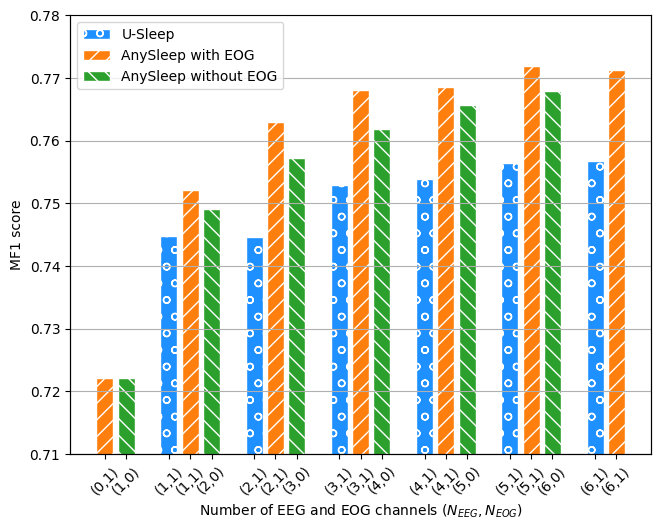

In [3]:
plt.figure(figsize=(7.5, 5.7))
means = np.array([np.mean(v) for v in mf1_per_n_ch_exp001a.values()])
stds = np.array([np.std(v) for v in mf1_per_n_ch_exp001a.values()])
print(f"USleep: {means}")
plt.bar(np.array(list(mf1_per_n_ch_exp001a.keys())) + 0.75, means, width=0.2,
        label="U-Sleep", hatch="o", edgecolor="white", color="dodgerblue")

scores_concat = {k: np.concatenate(v, axis=0) for k, v in mf1_per_n_ch_exp002a.items()}
means = np.array([np.mean(v) for v in scores_concat.values()])
stds = np.array([np.std(v) for v in scores_concat.values()])
print(f"AnySleep with EOG: {means}")
plt.bar(np.array(list(mf1_per_n_ch_exp002a.keys())) + 1, means, width=0.2,
        label="AnySleep with EOG", hatch="//", edgecolor="white", color="tab:orange")

scores_concat = {k: np.concatenate(v, axis=0) for k, v in mf1_per_n_ch_exp002a_no_eog.items()}
means = np.array([np.mean(v) for v in scores_concat.values()])
stds = np.array([np.std(v) for v in scores_concat.values()])
print(f"AnySleep without EOG: {means}")
plt.bar(np.array(list(mf1_per_n_ch_exp002a_no_eog.keys())) + 0.25, means, width=0.2,
        label="AnySleep without EOG", hatch="\\\\", edgecolor="white", color="tab:green")

plt.xticks([])
plt.ylabel("MF1 score")
plt.legend()
plt.ylim(0.71, 0.78)
plt.grid()

# top axis
ax = plt.gca()
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())  # important: sync ranges
# choose tick locations (use same centers so they align)
ax_top.set_xticks([1, 1.25, 1.75, 2, 2.25, 2.75, 3, 3.25, 3.75, 4, 4.25, 4.75, 5, 5.25, 5.75, 6, 6.25, 6.75, 7],
                  ["(0,1)", "(1,0)", "(1,1)", "(1,1)", "(2,0)", "(2,1)", "(2,1)", "(3,0)", "(3,1)", "(3,1)", "(4,0)",
                   "(4,1)", "(4,1)", "(5,0)", "(5,1)", "(5,1)", "(6,0)", "(6,1)", "(6,1)"], rotation=45)
ax_top.set_xlabel("Number of EEG and EOG channels $(N_{EEG}, N_{EOG})$")

# move the twin's ticks/label to the bottom and offset them so they don't overlap
ax_top.xaxis.set_ticks_position('bottom')
ax_top.xaxis.set_label_position('bottom')
ax_top.spines['top'].set_visible(False)  # hide its top spine if present

plt.savefig("n_eeg_ch_vs_mf1.svg", bbox_inches="tight")
plt.show()

In [4]:
# statistical tests
from scipy import stats

for n_eeg in range(7):
    w_eog = np.concatenate(mf1_per_n_ch_exp002a[n_eeg], axis=0)

    if n_eeg < 6:
        # test AnySleep with EOG vs AnySleep without EOG
        no_eog = np.concatenate(mf1_per_n_ch_exp002a_no_eog[n_eeg + 1], axis=0)
        t_stat, p_val = stats.ttest_ind(w_eog, no_eog, equal_var=False, alternative="greater")
        print(f"AnySleep with EOG vs AnySleep without EOG, n_eeg={n_eeg}: {p_val:.3f}")
        print(f"means: {np.mean(w_eog)}, {np.mean(no_eog)}")

    if n_eeg > 0:
        # test USleep vs AnySleep with EOG
        usleep = np.concatenate(mf1_per_n_ch_exp001a[n_eeg], axis=0)
        t_stat, p_val = stats.ttest_ind(usleep, w_eog, equal_var=False, alternative="less")
        print(f"USleep vs AnySleep with EOG, n_eeg={n_eeg}: {p_val:.3f}")
        print(f"means: {np.mean(usleep)}, {np.mean(w_eog)}")

    print()

AttUSleep with EOG vs AttUSleep without EOG, n_eeg=0: 0.496
means: 0.722093666491289, 0.7220833165818753

AttUSleep with EOG vs AttUSleep without EOG, n_eeg=1: 0.002
means: 0.752162075372869, 0.7490299233870537
USleep vs AttUSleep with EOG, n_eeg=1: 0.000
means: 0.7447510856184925, 0.752162075372869

AttUSleep with EOG vs AttUSleep without EOG, n_eeg=2: 0.000
means: 0.7628946251080814, 0.7571881158870769
USleep vs AttUSleep with EOG, n_eeg=2: 0.000
means: 0.7446771218300678, 0.7628946251080814

AttUSleep with EOG vs AttUSleep without EOG, n_eeg=3: 0.000
means: 0.7680873536632958, 0.7618586802126432
USleep vs AttUSleep with EOG, n_eeg=3: 0.000
means: 0.7529697576143102, 0.7680873536632958

AttUSleep with EOG vs AttUSleep without EOG, n_eeg=4: 0.003
means: 0.7685800413272865, 0.7656607903887085
USleep vs AttUSleep with EOG, n_eeg=4: 0.000
means: 0.7538442840860788, 0.7685800413272865

AttUSleep with EOG vs AttUSleep without EOG, n_eeg=5: 0.000
means: 0.7718574751531349, 0.767921826211487